In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from home_ownership import bottom_line

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Sources of Revenue
Rent Averted: 45183
House Sale: 112550

Costs
Recurring Ownership Cost: 11078
DP Opportunity_costs: 5249
Interest Paid: 6799 
Principal + DP Paid: 37205 
DP + Interest + Principal: 44005
Rest of Loan: 62794


Bottom Line: 34606


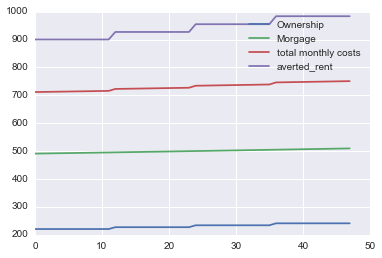

In [7]:
d = {
'home_price' : 100000.0,
'down_payment' : 0.2,
'maintenance': 0.01,
'home_owners_insurance': 0.0056,
'mortgage_term' : 15,
'mortgage_rate' : 0.037,
'property_tax' : 0.017,
'marginal_tax_rate' : 0.36,
'stock_market' : 0.06,
'house_appreciation' : 0.03,
'years'  : 4,
'income_rent'  : 900,
'personal_rent' : 900,
'rent_rate' : 0.03,
}

bottom_line(d, income = False)